./test


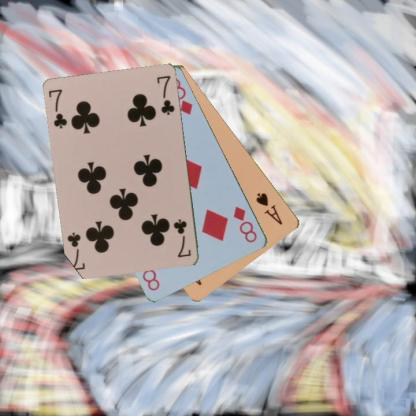

In [87]:
import pandas as pd
import yaml
import os
#import cv2                  #conda install conda-forge::opencv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import PIL.Image as Image
from tqdm.notebook import tqdm
%run parallel_functions.py
from parallel_functions import read_image_and_bbox, read_and_process_file
from joblib import Parallel, delayed
import lightning as L
import torch
import imageio.v2 as imageio


with open('data.yaml', 'r') as f:
    train_data = yaml.safe_load(f)
    number_classes=train_data['nc']
    classes=train_data['names']
    
test_path="./test"

num_jobs=16

print(test_path)


class_dict={}
for i in range(number_classes):
    class_dict[i+1]=classes[i]
class_dict[0]='None'
number_classes=len(class_dict)

sample_image_path="/home/bernd/_developer/cards_object_detection/test/images/000246247_jpg.rf.fb915aef7c063ce2ac971f8de0d8b2c1.jpg"
sample_image = imageio.imread(sample_image_path)
sample_image = Image.fromarray(sample_image)

sample_image


In [88]:
import torchvision
from torchvision.models import ResNet50_Weights
import torch
import gc
import sys

class Model(L.LightningModule):
    def __init__(self, loss_fun=None, hidden_size=None, dropout=0.4, params=None, train_dataset=None, val_dataset=None):
        super().__init__()
        self.backbone=torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.backbone_output_size=1000
        number_boxes=4
        self.neurons_per_box=4      
        output_neurons=number_boxes*self.neurons_per_box
        self.loss_fun=loss_fun
        self.params=params
        self.train_dataset=train_dataset
        self.val_dataset=val_dataset
        
        self.head=torch.nn.Sequential(
            torch.nn.Linear(self.backbone_output_size, hidden_size),
            torch.nn.BatchNorm1d(hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=dropout),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.BatchNorm1d(hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=dropout),
            torch.nn.Linear(hidden_size, output_neurons),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x=self.backbone(x)
        x=x.view(-1, self.backbone_output_size)
        x=self.head(x)
        return x
 
    def validation_step(self, batch, batch_idx):
        image, target, _ = batch
        output = self(image)
        loss = self.loss_fun(output, target['boxes'])
        self.custom_log("val_loss", loss.detach())
        return loss
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self(batch)
        
from lightning.pytorch.callbacks import ModelCheckpoint


# loader model from checkpoint
bbox_model = Model.load_from_checkpoint(
    checkpoint_path='/home/bernd/_developer/cards_object_detection/cards_bbox-epoch=36-val_loss=44.92.ckpt', hidden_size=1000
)
bbox_model.eval()


from typing import Any
from torchvision.models import ResNet18_Weights

class Model(L.LightningModule):
    def __init__(self, number_classes):
        super(Model, self).__init__()
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=ResNet18_Weights.DEFAULT)
        hidden_size = 1000
        self.model.fc = torch.nn.Sequential(
            torch.nn.Linear(512, hidden_size),
            torch.nn.BatchNorm1d(hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.0),
            torch.nn.Linear(hidden_size, number_classes)
        )
        
    def forward(self, x):
        return self.model(x)

classifier_model = Model(number_classes)
classifier_model.load_state_dict(torch.load("model_classifier.pth"))
classifier_model.eval()

device=torch.device('cpu')
bbox_model=bbox_model.to(device)
classifier_model=classifier_model.to(device)
bbox_model.eval()
classifier_model.eval()


Using cache found in /home/bernd/.cache/torch/hub/pytorch_vision_v0.10.0


Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [89]:
from torchvision import transforms
def show_boxes(image_data, show_class=False, ax=None):
    image=image_data['image']
    if ax is None:
        fig, ax = plt.subplots(1)
    ax.imshow(image)
    width, height = image.size
    bboxes=image_data["chunck"]
    
    for i in range(len(bboxes)):
        bbox=bboxes.iloc[i]
        x, y, w, h = bbox['x']*width, bbox['y']*height, bbox['w']*width, bbox['h']*height
        rect = patches.Rectangle((x-w/2, y-h/2), w, h, linewidth=1, edgecolor='r', facecolor='none')	
        if show_class:
            ax.text(x-w/2, y-h/2, class_dict[bbox['class']], fontsize=12, color='white', backgroundcolor='red')
        ax.add_patch(rect)
    return ax

def extract_images(image_data):
    image=image_data['image']
    width, height = image.size
    bboxes=image_data["chunck"]
    images=[]
    for idx, bbox in bboxes.iterrows():
        x, y, w, h = bbox['x']*width, bbox['y']*height, bbox['w']*width, bbox['h']*height
        image_crop=image.crop((x-w/2-4, y-h/2-4, x+w/2+8, y+h/2+8))
        images.append({
            "image": image_crop
        })
    return images

classifier_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

bbox_transform = transforms.Compose([transforms.ToTensor()])



CPU times: user 716 ms, sys: 10 ms, total: 726 ms
Wall time: 91.4 ms


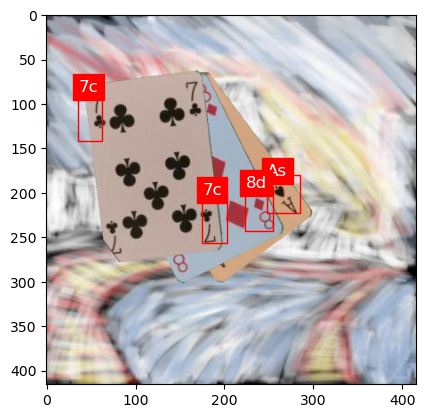

In [98]:
def predict_boxes_with_labels(image):
    image=bbox_transform(image)
    sample_image=image.unsqueeze(0)
    bbox_preds = bbox_model(sample_image)
    
    bboxes=[]
    for i in range(4):
        bboxes.append(bbox_preds[0][i*4:(i+1)*4].detach().numpy())
    image=sample_image[0].permute(1, 2, 0).numpy()
    image = Image.fromarray((image * 255).astype(np.uint8))
    image_with_bbox = {"image": image, "chunck": pd.DataFrame(bboxes, columns=['x', 'y', 'w', 'h'])}
    
    single_images=extract_images(image_with_bbox)
    
    single_images_processed=[]
    for image in single_images:
        single_images_processed.append(classifier_transform(image["image"]))
    single_images_tensor=torch.stack(single_images_processed)
    classfier_preds = classifier_model(single_images_tensor)
    classfier_preds=classfier_preds.argmax(dim=-1).detach().cpu().numpy()
  
    for j in range(len(image_with_bbox["chunck"])):
        image_with_bbox["chunck"].loc[j, "class"]=classfier_preds[j] 
    show_boxes(image_with_bbox, show_class=True)   
    
            
    
%time predict_boxes_with_labels(sample_image)

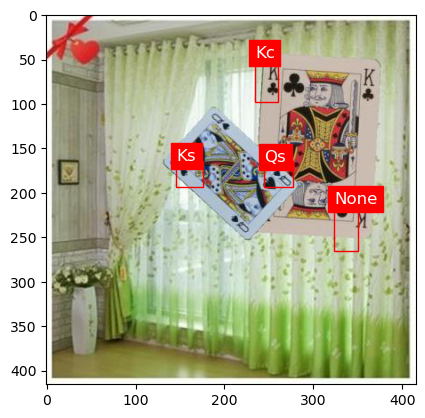

In [100]:
sample_image_path="/home/bernd/_developer/cards_object_detection/test/images/997002922_jpg.rf.25af4db583bc698d533b939691ae9287.jpg"
sample_image = imageio.imread(sample_image_path)
sample_image = Image.fromarray(sample_image)
predict_boxes_with_labels(sample_image)